# Data analysis 1

- __Data__ __Loading__
    - Load the dataset
    - Check for null
    - remove anomalies
- __Data__ __Analysis__
    - Check for __trend__ (moving average)
    - determine trend features using deterministic process (no need to create yet, just specify in comments)
    - provide visualization of the trend
    - Check for __seasonality__ (seasonal plot and periodogram)
    - determine seaosnality features using deterministic process (add on trend features, juts specify in comments)
    - provide visualization
- __Data__ __Processing__
    - make the trend and seasonality features.
    - make the sliding window features.
    - Combine the features and target into one dataframe
    - Divide the dataframe into training, validation, testing (70, 20, 10)
    - remove outliers (depends, research)
    - normalization
    - inverse
- __LSTM__ __Model__
    - hyperparameter tuning (batch, epochs, etc)
    - visualization

## Data Loading

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# define needed columns
desired_columns=["timestamp", "avg cpu"]
new_column_names = {"timestamp": "time", "avg cpu": "avg_cpu"}

#read the csv file and then specify the desired columns
df=pd.read_csv("cpu_util.csv", usecols=desired_columns, parse_dates=["timestamp"])

#rename columns to new names
df=df.rename(columns=new_column_names)

#set the time column to index and make it into period
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
df=df.set_index("time")

C:\Users\HP 15\AppData\Local\Temp\ipykernel_9436\3136523437.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


In [3]:
#checkpoint
df.head()

,avg_cpu
time,
2017-01-01 00:00:00,1.229569e+06
2017-01-01 00:05:00,1.211322e+06
2017-01-01 00:10:00,1.206635e+06
2017-01-01 00:15:00,1.190369e+06
2017-01-01 00:20:00,1.180992e+06


In [4]:
# check the end entries
df.tail()

,avg_cpu
time,
2017-01-30 23:35:00,1.242129e+06
2017-01-30 23:40:00,1.235937e+06
2017-01-30 23:45:00,1.224276e+06
2017-01-30 23:50:00,1.201533e+06
2017-01-30 23:55:00,1.207906e+06


In [4]:
# Check for null values in avg_cpu
null_values = df["avg_cpu"].isnull().sum()

# Print the number of null values
print(f"Number of null values in avg_cpu: {null_values}")

Number of null values in avg_cpu: 0


In [5]:
# check the amount of entries
print(df.shape)

(8640, 1)


In [7]:
df["avg_cpu"]

time
2017-01-01 00:00:00    1.229569e+06
2017-01-01 00:05:00    1.211322e+06
2017-01-01 00:10:00    1.206635e+06
2017-01-01 00:15:00    1.190369e+06
2017-01-01 00:20:00    1.180992e+06
                           ...     
2017-01-30 23:35:00    1.242129e+06
2017-01-30 23:40:00    1.235937e+06
2017-01-30 23:45:00    1.224276e+06
2017-01-30 23:50:00    1.201533e+06
2017-01-30 23:55:00    1.207906e+06
Name: avg_cpu, Length: 8640, dtype: float64

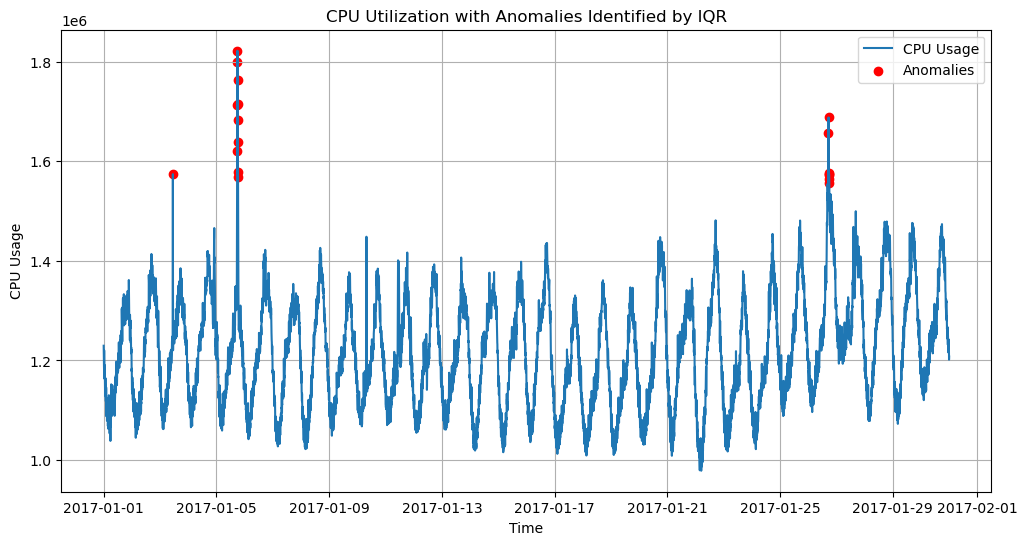

In [6]:
# Calculate IQR
Q1 = df['avg_cpu'].quantile(0.25)
Q3 = df['avg_cpu'].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold to identify anomalies (e.g., 1.5 * IQR)
iqr_threshold = 1.5
lower_bound = Q1 - iqr_threshold * IQR
upper_bound = Q3 + iqr_threshold * IQR
anomalies_iqr = df[(df['avg_cpu'] < lower_bound) | (df['avg_cpu'] > upper_bound)]

# Mark anomalies
df['anomaly'] = (df['avg_cpu'] < lower_bound) | (df['avg_cpu'] > upper_bound)

# Plot the anomalies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['avg_cpu'], label='CPU Usage')
plt.scatter(anomalies_iqr.index, anomalies_iqr['avg_cpu'], color='red', label='Anomalies')
plt.title('CPU Utilization with Anomalies Identified by IQR')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
df.head()

,avg_cpu,anomaly
time,,
2017-01-01 00:00:00,1.229569e+06,False
2017-01-01 00:05:00,1.211322e+06,False
2017-01-01 00:10:00,1.206635e+06,False
2017-01-01 00:15:00,1.190369e+06,False
2017-01-01 00:20:00,1.180992e+06,False


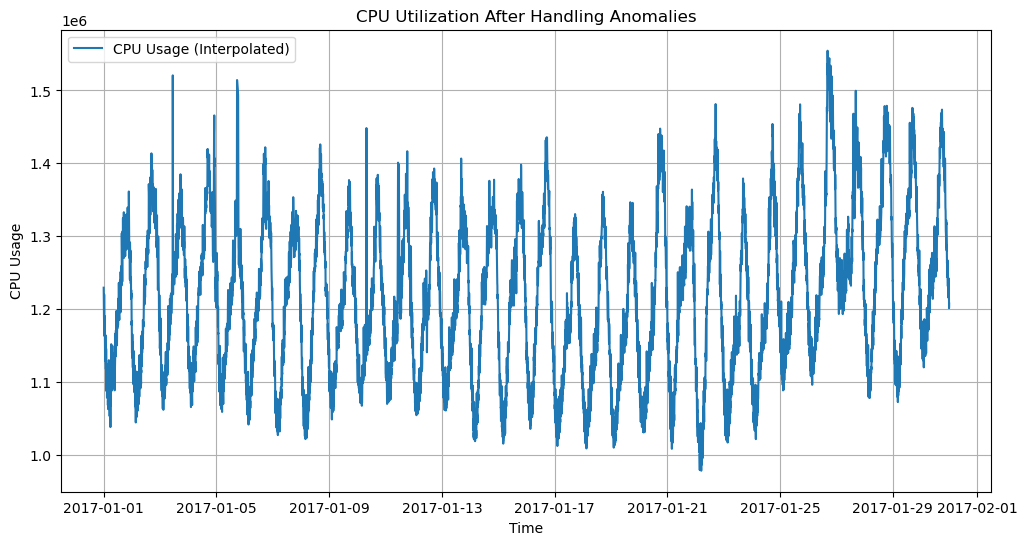

In [7]:
# Interpolating anomalies
df['avg_cpu'] = np.where(df['anomaly'] == True, np.nan, df['avg_cpu'])
df['avg_cpu'] = df['avg_cpu'].interpolate(method='time')

# Drop the anomaly column as it's no longer needed
df = df.drop(columns=['anomaly'])

# Plot the data after interpolation
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['avg_cpu'], label='CPU Usage (Interpolated)')
plt.title('CPU Utilization After Handling Anomalies')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(True)
plt.show()

Gathered information:
- consist of a timestamp index
    - starts at 2017-01-01 00:00
    - has an interval of 5 minutes
    - goes on for one month
    - anomalies are detected with IQR - doesn't fit the trend
    - Solving anomalies:
        - NO dropping rows - might disrupt the time series and intervals
        - USE interpolation - impute the anomalies
- consist of another column called avg_cpu which shows average cpu utilization   

## Data Analysis

### Trend

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

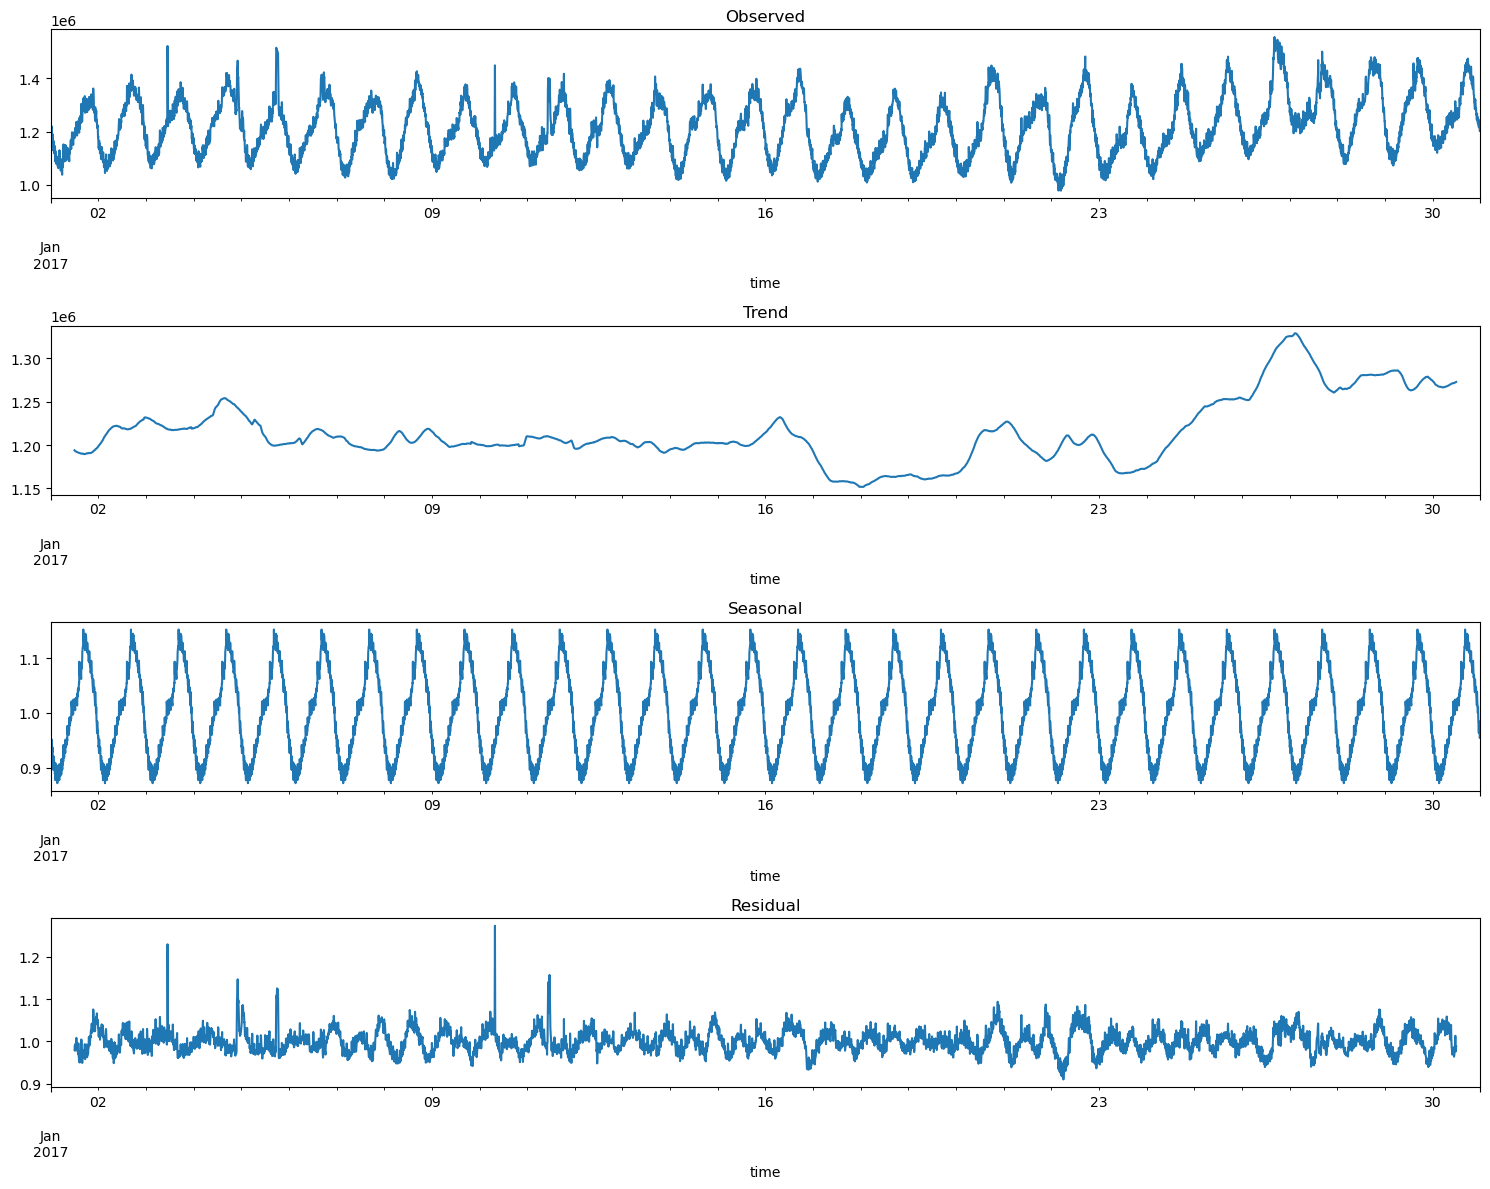

In [12]:
# Create a copy of the dataframe for trend analysis
df_trend = df.copy()

# Decompose the time series
decomposition = seasonal_decompose(df_trend['avg_cpu'], model='multiplicative', period=24*12)  # 24 hours * 12 intervals per hour

# Plotting the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

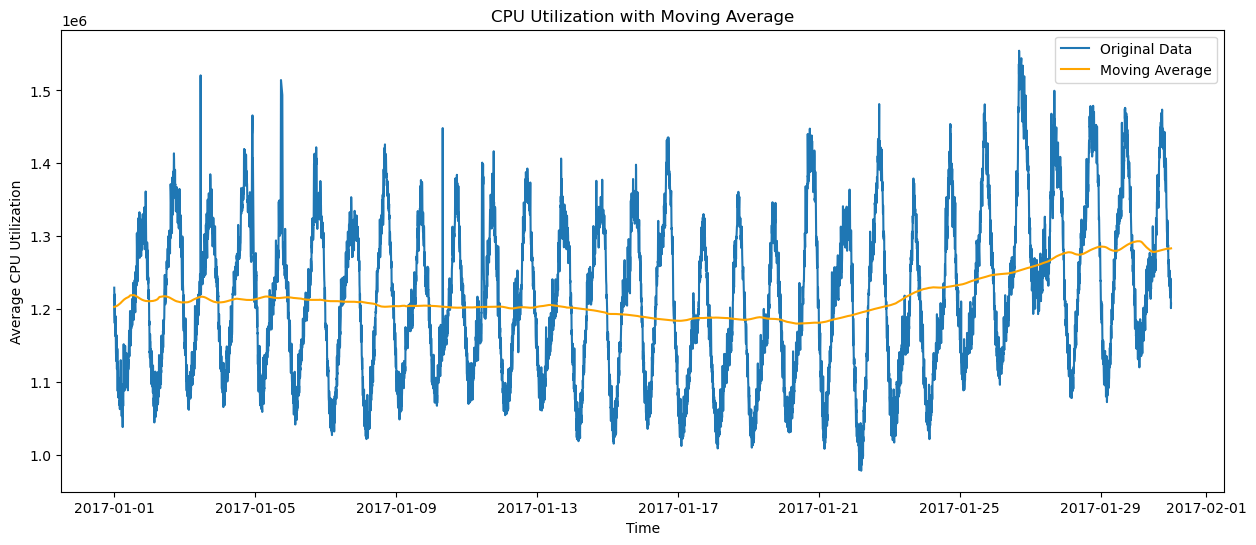

In [13]:
# Calculate the moving average with a window size of 288 (24 hours) and a minimum period of 144 (12 hours)
# first try: 24 hours * 12 intervals per hour (since it's 5-minute intervals) or ONE DAY : trend line not smooth enough
# second try: one week=2016 5 minutes intervals, smoother trend line
window_size = 2016
min_periods = window_size // 2  # Half the window size (12 hours)

moving_average = df_trend.rolling(
    window=window_size,  
    center=True,        
    min_periods=min_periods  
).mean()

# Plotting the original data and the moving average
plt.figure(figsize=(15, 6))
plt.plot(df_trend['avg_cpu'], label='Original Data')
plt.plot(moving_average, label='Moving Average', color='orange')
plt.title('CPU Utilization with Moving Average')
plt.xlabel('Time')
plt.ylabel('Average CPU Utilization')
plt.legend()
plt.show()

### Seasonality

In [8]:
# Create a copy fo the dataframe for seasonality analysis
df_snl = df.copy()

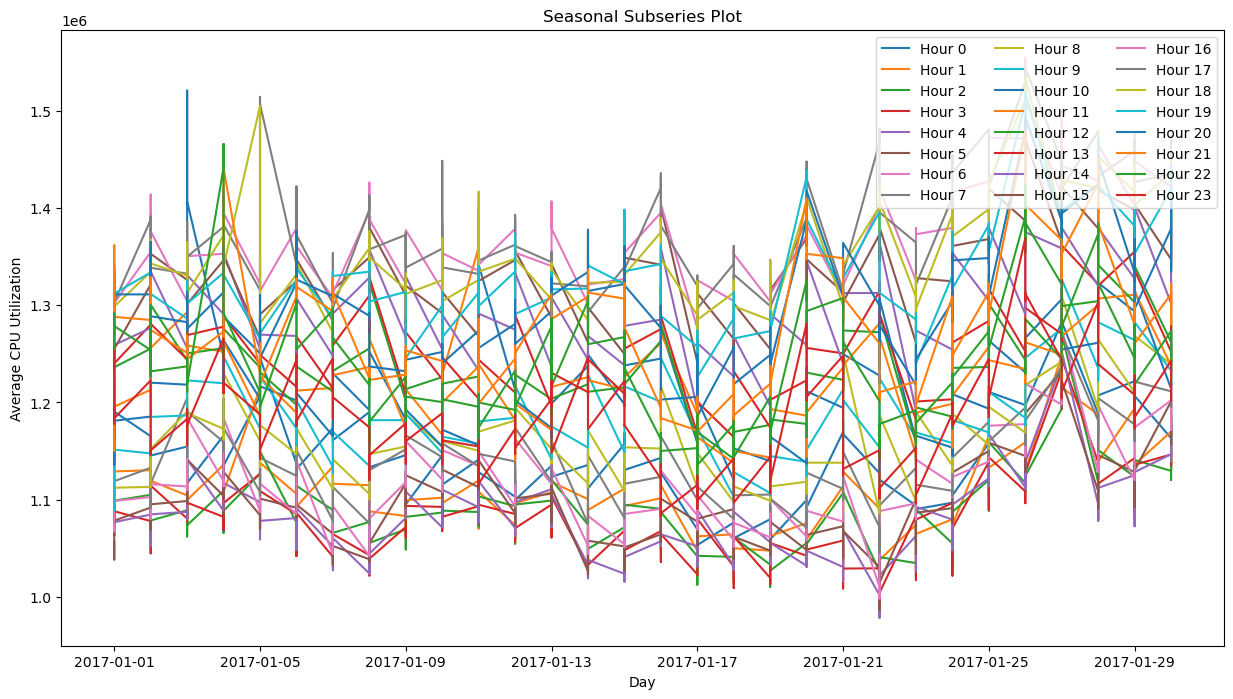

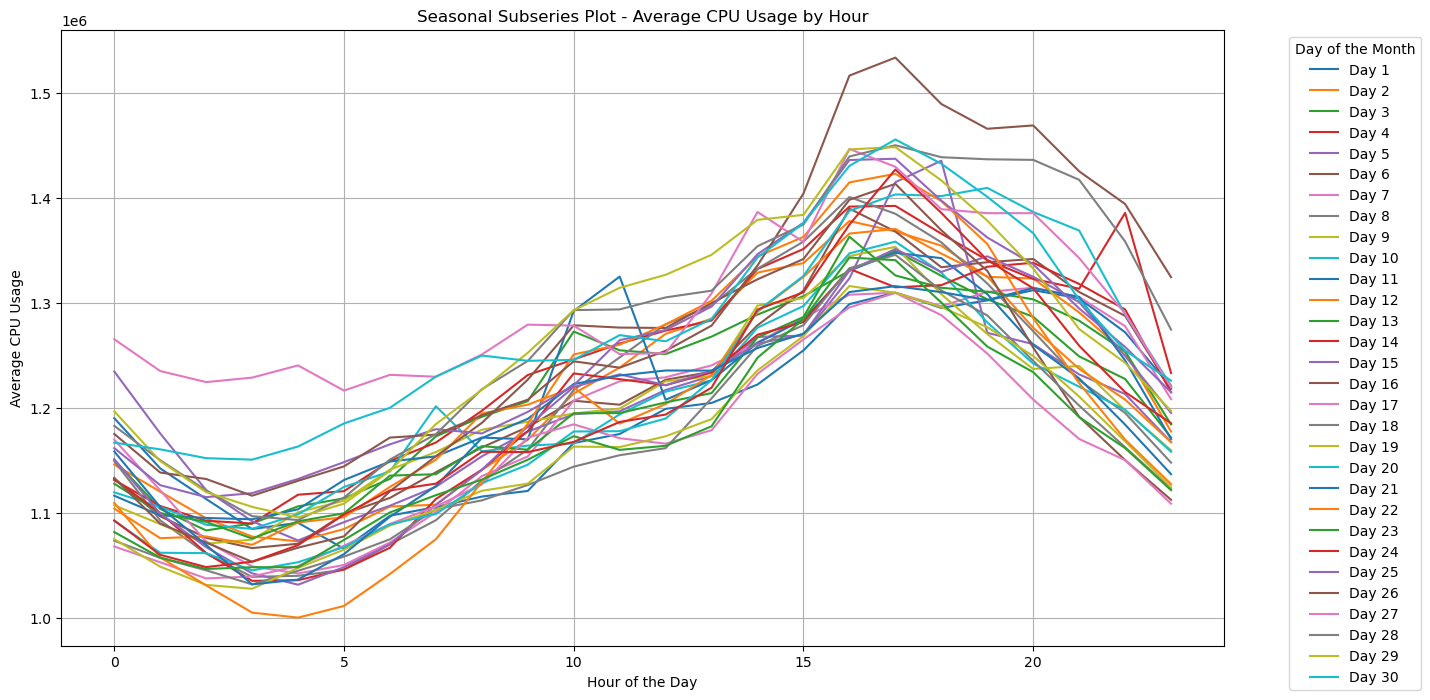

In [15]:
import seaborn as sns

# Create a seasonal subseries plot
def seasonal_subseries_plot(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.date
    plt.figure(figsize=(15, 8))
    for hour in range(24):
        subset = df[df['hour'] == hour]
        plt.plot(subset['day'], subset['avg_cpu'], label=f'Hour {hour}')
    plt.title('Seasonal Subseries Plot')
    plt.xlabel('Day')
    plt.ylabel('Average CPU Utilization')
    plt.legend(loc='upper right', ncol=3)
    plt.show()
    

# Create a month-season plot
def month_season_plot(df):
    # Assuming df is your DataFrame with a DateTime index and 'avg_cpu' column
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    # Calculate the average CPU usage for each hour of each day
    avg_hourly_usage = df.groupby(['day', 'hour'])['avg_cpu'].mean().unstack()
    
    # Plot the seasonal subseries plot
    plt.figure(figsize=(15, 8))
    for day in avg_hourly_usage.index:
        plt.plot(avg_hourly_usage.columns, avg_hourly_usage.loc[day], label=f'Day {day}')
    
    plt.title('Seasonal Subseries Plot - Average CPU Usage by Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average CPU Usage')
    plt.legend(title='Day of the Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Plot the seasonal subseries plot
seasonal_subseries_plot(df_snl)

# Plot the month-season plot
month_season_plot(df_snl)

In [16]:
#df_snl=df_snl.drop(['hour', 'day'], axis=1, inplace=False)
df_snl.head()

,avg_cpu,hour,day
time,,,
2017-01-01 00:00:00,1.229569e+06,0,1
2017-01-01 00:05:00,1.211322e+06,0,1
2017-01-01 00:10:00,1.206635e+06,0,1
2017-01-01 00:15:00,1.190369e+06,0,1
2017-01-01 00:20:00,1.180992e+06,0,1


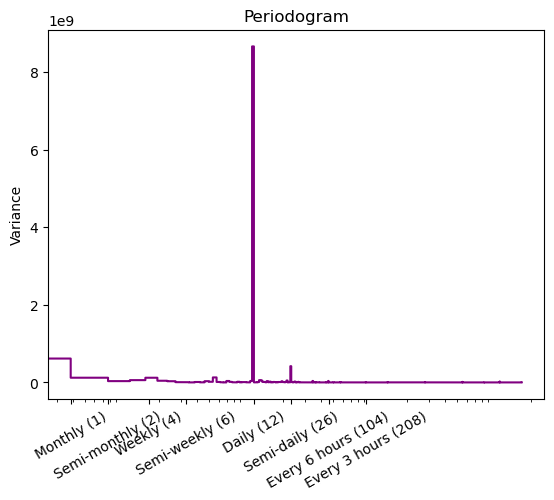

In [9]:
from scipy.signal import periodogram

# Function to plot the periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = 1 / pd.Timedelta("5min").total_seconds()  # Frequency in Hz (samples per second)
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([
        1 / (30 * 24 * 60 * 60),  # Monthly
        1 / (15 * 24 * 60 * 60),  # Semi-monthly
        1 / (7 * 24 * 60 * 60),   # Weekly
        1 / (3.5 * 24 * 60 * 60), # Semi-weekly
        1 / (24 * 60 * 60),       # Daily
        1 / (12 * 60 * 60),       # Semi-daily
        1 / (6 * 60 * 60),        # Every 6 hours
        1 / (3 * 60 * 60),        # Every 3 hours
    ])
    ax.set_xticklabels(
        [
            "Monthly (1)",
            "Semi-monthly (2)",
            "Weekly (4)",
            "Semi-weekly (6)",
            "Daily (12)",
            "Semi-daily (26)",
            "Every 6 hours (104)",
            "Every 3 hours (208)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Plot the periodogram
plot_periodogram(df_snl['avg_cpu'])
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.impute import SimpleImputer

RMSE with orders 40, 15, 20: 35564.06191811214


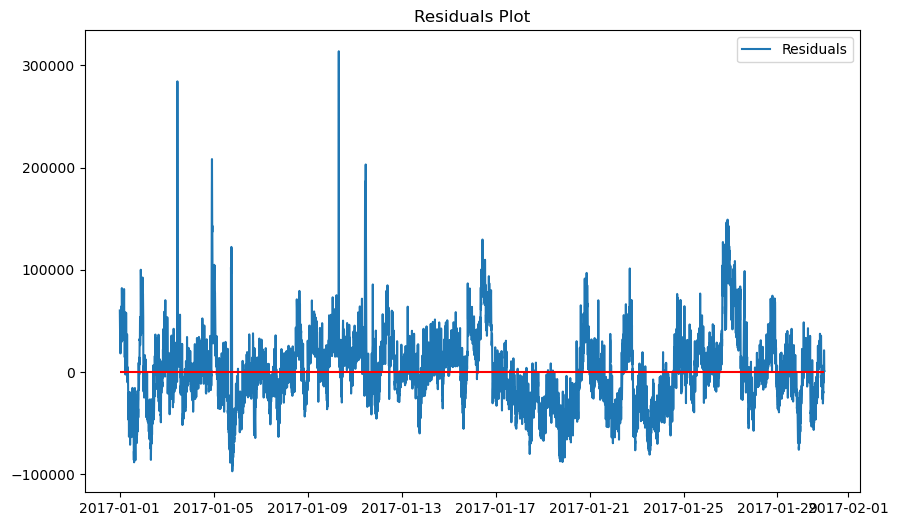

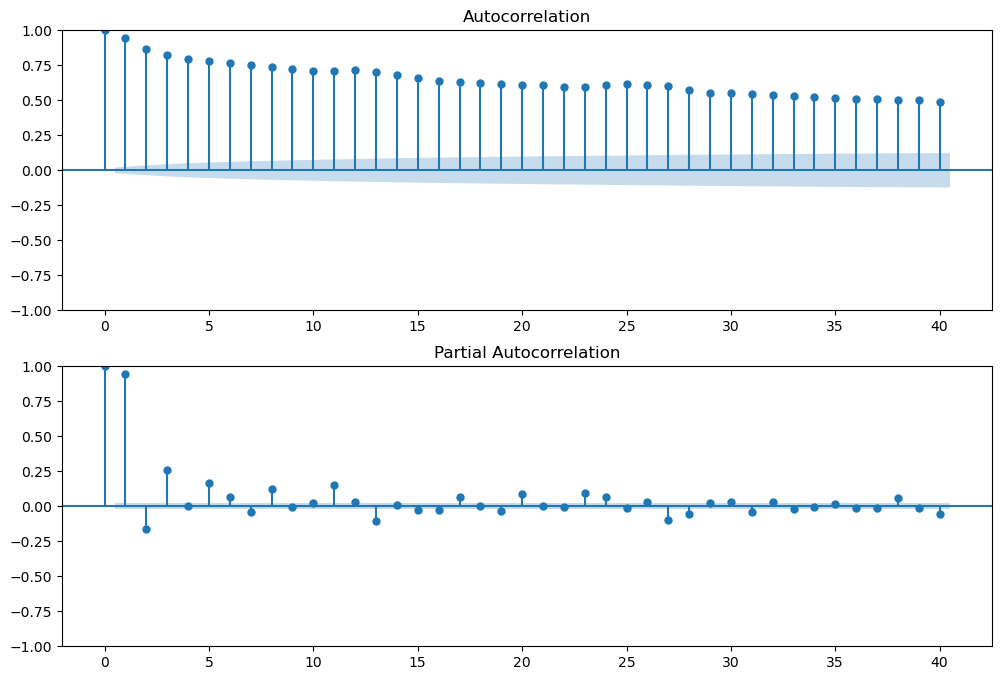

In [19]:

# Sample DataFrame creation (replace with actual data)
#df_copied = pd.DataFrame({
#    'timestamp': pd.date_range(start='2017-01-01', periods=8928, freq='5T'),
#    'avg_cpu': np.random.rand(8928) * 100  # Replace with actual CPU utilization data
#})
#df_copied.set_index('timestamp', inplace=True)
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals')
    plt.hlines(0, xmin=y_true.index.min(), xmax=y_true.index.max(), colors='r')
    plt.title('Residuals Plot')
    plt.legend()
    plt.show()
    return residuals

def plot_acf_pacf(residuals):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(residuals, ax=ax[0])
    plot_pacf(residuals, ax=ax[1])
    plt.show()

# Additional time-based features
df_snl['hour'] = df_snl.index.hour
df_snl['day_of_week'] = df_snl.index.dayofweek
df_snl['day_of_month'] = df_snl.index.day
df_snl['week_of_year'] = df_snl.index.isocalendar().week
df_snl['hour_day_of_week'] = df_snl['hour'] * df_snl['day_of_week']

def fit_model_and_evaluate(fourier_daily_order, fourier_semi_daily_order, fourier_weekly_order):
    # Define Fourier terms
    fourier_daily = CalendarFourier(freq="D", order=fourier_daily_order)
    fourier_semi_daily = CalendarFourier(freq="12h", order=fourier_semi_daily_order)
    fourier_weekly = CalendarFourier(freq="W", order=fourier_weekly_order)
    
    # Define the deterministic process with explicit period
    period = 24 * 60 // 5  # 288 for 5-minute intervals in a day
    
    # Define the deterministic process
    dp = DeterministicProcess(
        index=df_snl.index,
        constant=True,
        order=2,  # Polynomial order for trend
        seasonal=True,
        period=period,
        additional_terms=[fourier_daily, fourier_semi_daily, fourier_weekly],
        drop=True,
    )
    
    # Generate the deterministic features
    X_seasonal = dp.in_sample()
    X_seasonal['hour'] = df_snl['hour']
    X_seasonal['day_of_week'] = df_snl['day_of_week']
    X_seasonal['day_of_month'] = df_snl['day_of_month']
    X_seasonal['week_of_year'] = df_snl['week_of_year']
    X_seasonal['hour_day_of_week'] = df_snl['hour_day_of_week']
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_seasonal, df_snl['avg_cpu'])
    
    # Predict
    y_pred = model.predict(X_seasonal)
    
    # Evaluate
    rmse = evaluate_model(df_snl['avg_cpu'], y_pred)
    print(f'RMSE with orders {fourier_daily_order}, {fourier_semi_daily_order}, {fourier_weekly_order}: {rmse}')
    
    residuals = plot_residuals(df_snl['avg_cpu'], y_pred)
    plot_acf_pacf(residuals)

# Example: Evaluate with different orders
#fit_model_and_evaluate(24, 12, 8)  # Including 12-hour seasonality
#fit_model_and_evaluate(24, 12, 10) # Another set with 12-hour seasonality
#fit_model_and_evaluate(30, 12, 12) # Higher order for all seasonality
fit_model_and_evaluate(40, 15, 20) # Higher order for all seasonality with trend order 3


### Lag Features

In [60]:
# Create a copy fo the dataframe for lag analysis
df_lag = df.copy()

In [61]:
df_resampled = df_lag.resample('5min').mean()

In [62]:
df_resampled.head()

,avg_cpu
time,
2017-01-01 00:00:00,1.229569e+06
2017-01-01 00:05:00,1.211322e+06
2017-01-01 00:10:00,1.206635e+06
2017-01-01 00:15:00,1.190369e+06
2017-01-01 00:20:00,1.180992e+06


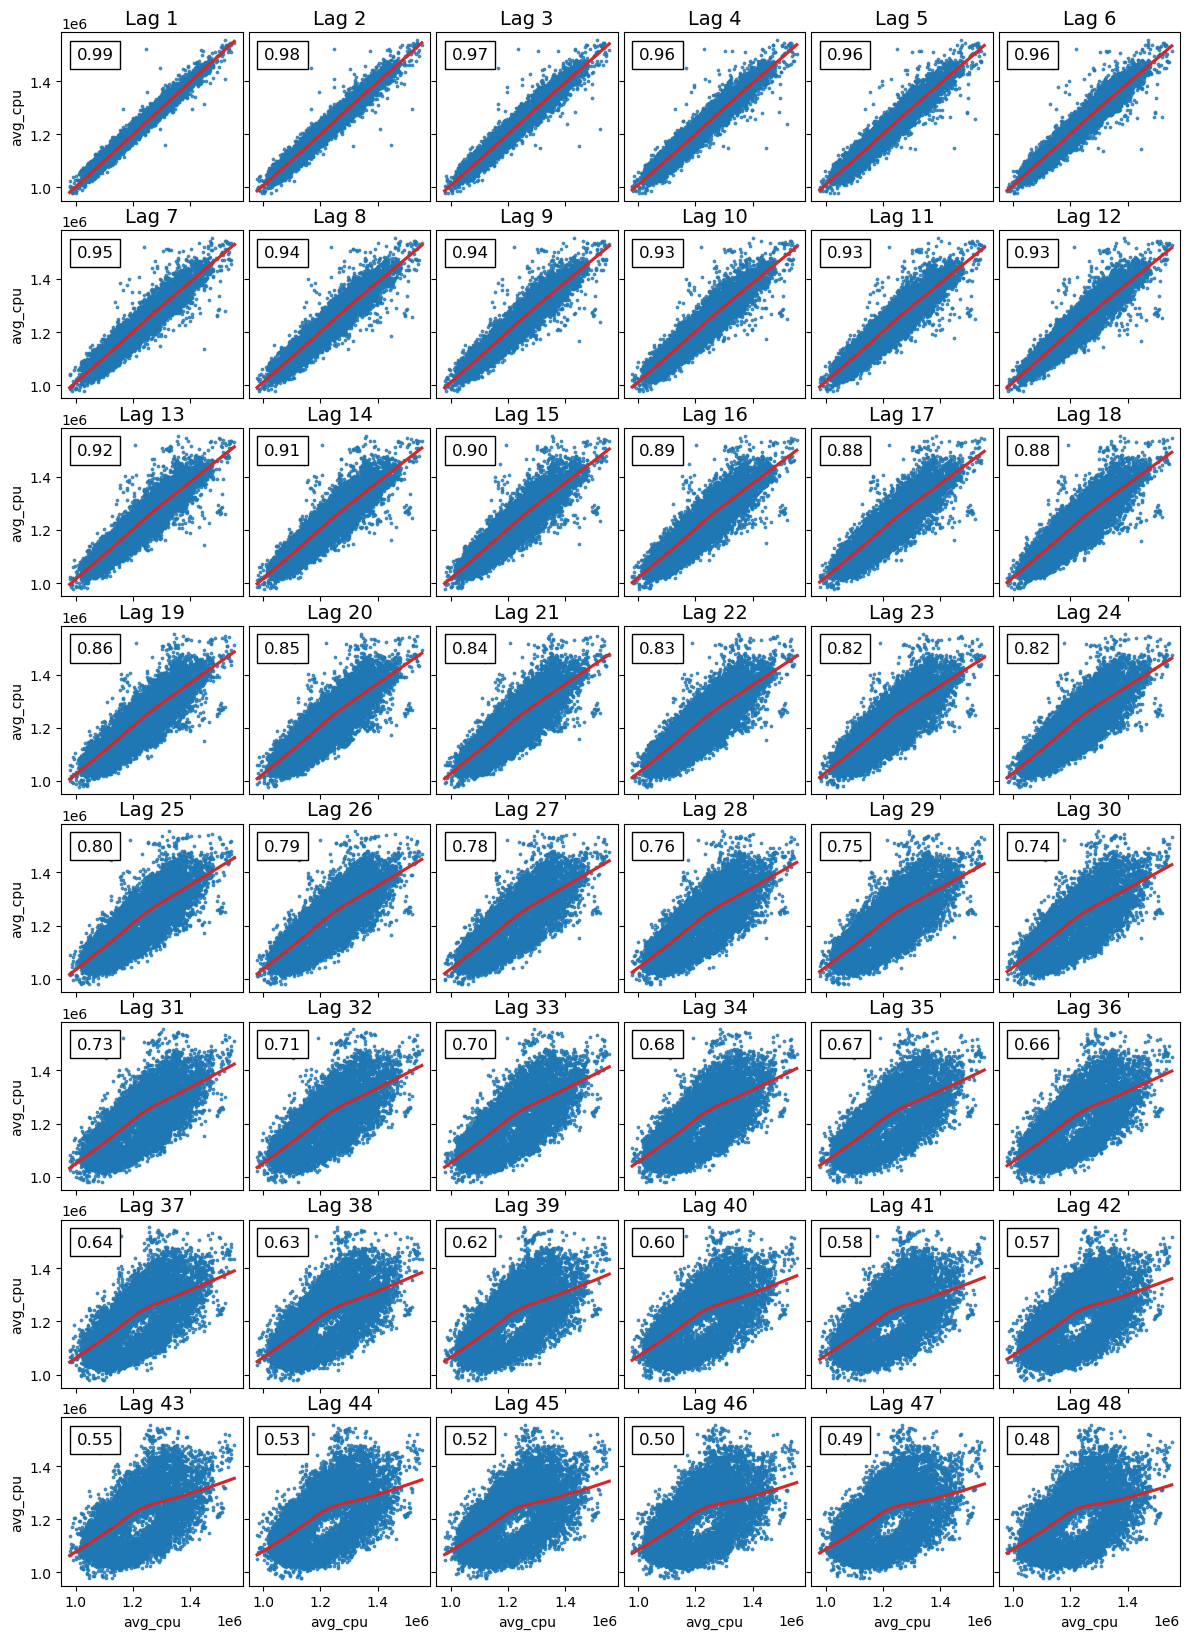

<Figure size 1000x500 with 0 Axes>

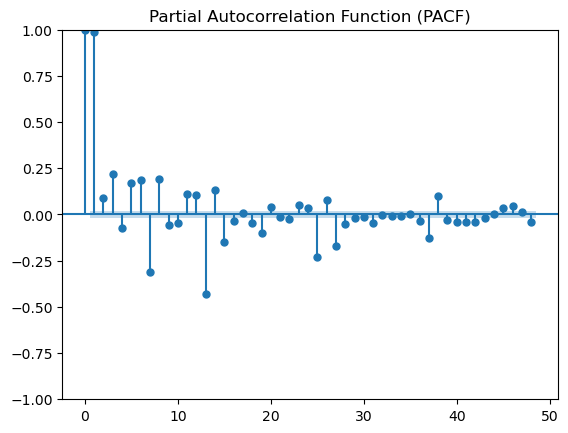

<Figure size 1000x500 with 0 Axes>

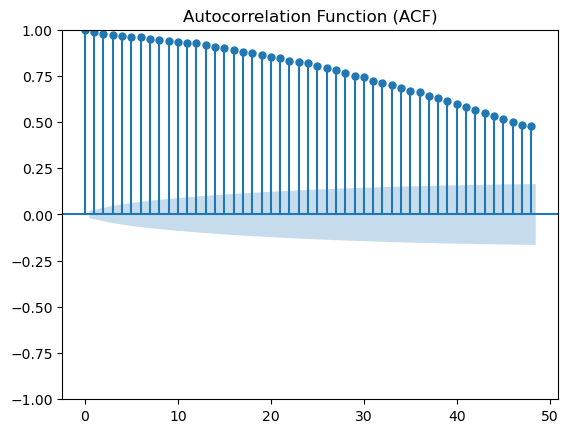

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=288, nrows=12, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


_ = plot_lags(df_resampled['avg_cpu'], lags=48, nrows=8)


plt.figure(figsize=(10, 5))
plot_pacf(df_resampled['avg_cpu'], lags=48)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


plt.figure(figsize=(10, 5))
plot_acf(df_resampled['avg_cpu'], lags=48)
plt.title('Autocorrelation Function (ACF)')
plt.show()


Findings:
- Saw a periodical time (ACF shows wave)
- Lags used: 8 lags (30 minutes resmaples for computational power)
- Reasons: good amount of relations, not much decay
- Not using 40-45 lags as it will be handled by the seasonality and tredn features
- Focus on short term lags
- In 5 minutes interval: __48 lags__